In [2]:
import torch
from torch import nn
import numpy as np
import torchaudio
import os
from numpy import sort

%matplotlib inline
import matplotlib.pyplot as plt

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Data Cleaning/Creation
## Prepare data to input into our model

In [3]:
def load_audio_data(data_directory):
    classes = sort(list(filter(lambda x: x[0] != '.', os.listdir(data_directory))))
    print(classes)

    data = []
    labels = []
    for i, c in enumerate(classes):
        for f in os.listdir(data_directory + c):
            try:
                waveform, sample_rate = torchaudio.load(data_directory + c + '/' + f)
                data.append((waveform, sample_rate))
                labels.append(i)
            except:
                continue

    return data, labels, classes

In [4]:
def split_audio_clips(data, labels, clip_duration):
    split_data = []
    split_labels = []

    for i, (waveform, sample_rate) in enumerate(data):
        # Calculate the number of samples in each clip
        clip_samples = int(sample_rate * clip_duration)

        # Split the waveform into clips
        for start in range(0, waveform.shape[1], clip_samples):
            end = start + clip_samples
            if end <= waveform.shape[1]:
                clip = waveform[:, start:end]
                split_data.append(clip)
                split_labels.append(labels[i])

    return split_data, split_labels

In [8]:
data_directory = 'Data/genres_original/'
data, labels, classes = load_audio_data(data_directory)
clip_duration = 3  # Desired clip duration in seconds
split_data, split_labels = split_audio_clips(data, labels, clip_duration)

print(split_data)
#print(split_labels)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
[tensor([[ 0.0428,  0.0680,  0.0608,  ..., -0.0234, -0.0253, -0.0256]]), tensor([[-0.0247, -0.0227, -0.0192,  ..., -0.0599, -0.0649, -0.0718]]), tensor([[-0.0790, -0.0846, -0.0888,  ..., -0.0264, -0.0282, -0.0280]]), tensor([[-0.0272, -0.0262, -0.0244,  ...,  0.1395,  0.1370,  0.1353]]), tensor([[ 0.1341,  0.1329,  0.1316,  ..., -0.1468, -0.1597, -0.1709]]), tensor([[-0.1792, -0.1827, -0.1789,  ..., -0.0451, -0.0490, -0.0511]]), tensor([[-0.0523, -0.0536, -0.0542,  ..., -0.0355, -0.0414, -0.0526]]), tensor([[-0.0666, -0.0809, -0.0932,  ..., -0.0511, -0.0477, -0.0444]]), tensor([[-0.0417, -0.0383, -0.0339,  ...,  0.0246,  0.0222,  0.0197]]), tensor([[0.0176, 0.0160, 0.0151,  ..., 0.0373, 0.0357, 0.0333]]), tensor([[0.3651, 0.5903, 0.5240,  ..., 0.0076, 0.0087, 0.0114]]), tensor([[0.0170, 0.0235, 0.0253,  ..., 0.1397, 0.1524, 0.1543]]), tensor([[0.1635, 0.1624, 0.1484,  ..., 0.1207, 0.1063, 0.0838]]), 

In [7]:
#load audio file data
# data_directory = 'Data/genres_original/'
# classes = sort(list(filter(lambda x: x[0] != '.', os.listdir(data_directory))))
# print(classes)

#  #make data 
# data = []
# labels = []
# for i, c in enumerate(classes):
#     for f in os.listdir(data_directory + c):
#         try: 
#             waveform, sample_rate = torchaudio.load(data_directory + c + '/' + f)
#             data.append(waveform)
#             labels.append(i)
#         except:
#             continue

# print(data)
#a waveform, sample_rate = torchaudio.load(data_directory + file_name)
# waveform = waveform[0]
# print("Shape of waveform: {}".format(waveform.size()))
# print("Sample rate of waveform: {}".format(sample_rate))




['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
[tensor([[ 0.0428,  0.0680,  0.0608,  ..., -0.0248, -0.0293, -0.0301]]), tensor([[ 0.3651,  0.5903,  0.5240,  ..., -0.0103, -0.0142, -0.0065]]), tensor([[0.0665, 0.0934, 0.0451,  ..., 0.0808, 0.0612, 0.0419]]), tensor([[ 0.1124,  0.1476,  0.1153,  ..., -0.1114, -0.1061, -0.0728]]), tensor([[ 0.1541,  0.1752,  0.0731,  ..., -0.2531, -0.2521, -0.1306]]), tensor([[-0.2370, -0.2969, -0.0810,  ...,  0.4903,  0.5562,  0.6030]]), tensor([[-0.0190, -0.0405, -0.0561,  ..., -0.0296,  0.0111,  0.0081]]), tensor([[-0.2136, -0.3572, -0.3143,  ..., -0.0575, -0.0187, -0.0102]]), tensor([[-0.0561, -0.1365, -0.1718,  ...,  0.0021,  0.0010,  0.0089]]), tensor([[ 0.0986,  0.1517,  0.1288,  ..., -0.0615, -0.0644, -0.0639]]), tensor([[-0.0034,  0.1512,  0.1884,  ..., -0.0520, -0.1149, -0.1341]]), tensor([[0.0316, 0.0513, 0.0490,  ..., 0.0600, 0.0592, 0.0514]]), tensor([[-0.1081, -0.1508, -0.1733,  ..., -0.1028, -0.0972, 

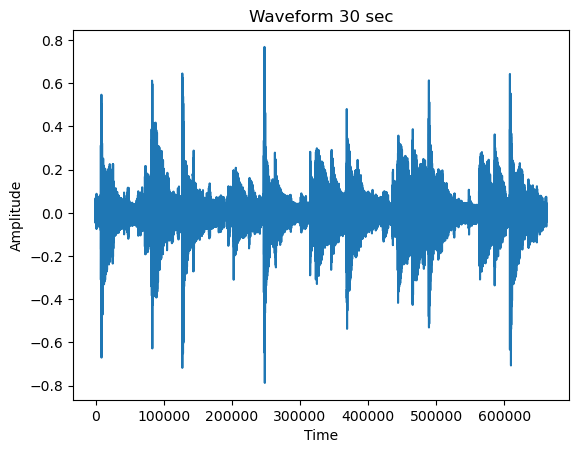

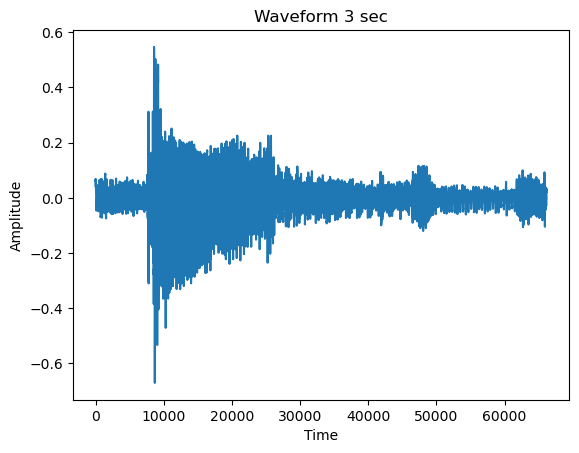

In [17]:
#print waveform 
w = data[0][0]
plt.figure()
plt.title('Waveform 30 sec')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(w.t().numpy())
plt.show()

w = split_data[0]
plt.figure()
plt.title('Waveform 3 sec')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(w.t().numpy())
plt.show()



In [11]:
# seperate data into training and testing so that there are equal labels in test set

#split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed, stratify=labels)
print(len(X_train), len(X_test), len(y_train), len(y_test))


799 200 799 200


# Creating a Model and Trainging It


In [12]:
class AudioClassificationModel(nn.Module):
    def __init__(self, n_input, n_channel, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=16),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(n_channel, n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(n_channel, 2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(2*n_channel, n_output)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
def train_audio_classification_model(model, X_train, y_train, n_epochs, lr):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        for i in range(len(X_train)):
            optimizer.zero_grad()
            y_pred = model(X_train[i])
            loss = criterion(y_pred, y_train[i])
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item()}')
        

def test_audio_classification_model(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(X_test)):
            y_pred = model(X_test[i])
            correct += (y_pred.argmax() == y_test[i])
            total += 1
    return correct / total
        

In [14]:
model = AudioClassificationModel(n_input=1, n_channel=16, n_output=len(classes))
train_audio_classification_model(model, X_train, y_train, n_epochs=10, lr=0.001)

TypeError: conv1d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
